Dataset Shape: (183416, 17)

User Type Distribution:
user_type
Subscriber    163548
Customer       19868
Name: count, dtype: int64

User Segment Distribution:
user_segment
Regular User          101728
Heavy User             61820
Potential Customer     19868
Name: count, dtype: int64

User Segment Encoding:
{'Heavy User': 0, 'Potential Customer': 1, 'Regular User': 2}

Tuning KNN hyperparameters...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best CV Score: 0.7817

K-Nearest Neighbors (Tuned) Performance:
Accuracy: 0.8280
Precision: 0.8011
Recall: 0.8280

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      4983
           1       0.54      0.10      0.17      1621
           2       0.85      0.98      0.91      8163

    accuracy                           0.83     14767
   macro avg       0.73      0

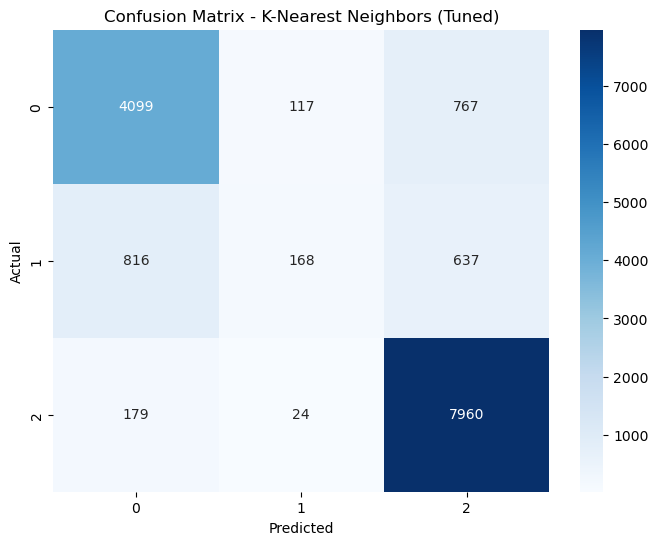


Tuning SVM hyperparameters...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV Score: 0.8725

Support Vector Machine (Tuned) Performance:
Accuracy: 0.8887
Precision: 0.7941
Recall: 0.8887

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4983
           1       0.00      0.00      0.00      1621
           2       0.93      1.00      0.97      8163

    accuracy                           0.89     14767
   macro avg       0.59      0.67      0.62     14767
weighted avg       0.79      0.89      0.84     14767



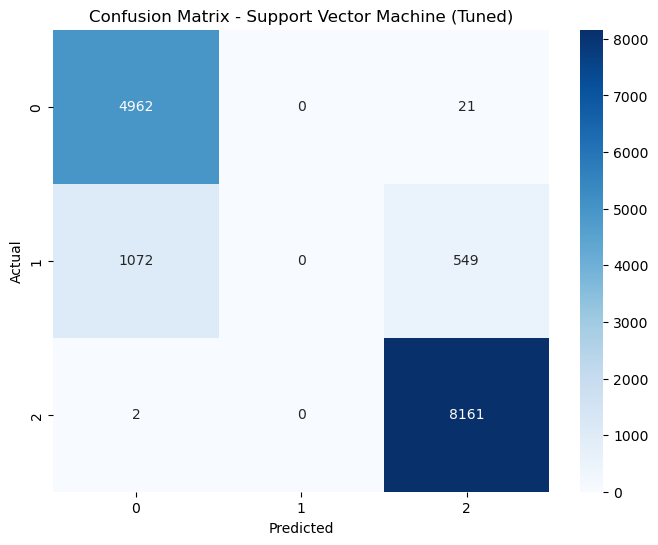


Tuning Deep Neural Network hyperparameters...
Testing DNN architectures...

Trying DNN configuration 1...
Configuration 1 - Val Accuracy: 0.8878, Val Loss: 0.3377

Trying DNN configuration 2...
Configuration 2 - Val Accuracy: 0.6893, Val Loss: 0.7230

Trying DNN configuration 3...
Configuration 3 - Val Accuracy: 0.6422, Val Loss: 0.8246

Best DNN Configuration: {'hidden_units1': 64, 'hidden_units2': 32, 'hidden_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.001}
Best Validation Accuracy: 0.8878
462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Deep Neural Network (Tuned) Performance:
Accuracy: 0.8883
Precision: 0.8826
Recall: 0.8883

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      4983
           1       0.81      0.02      0.03      1621
           2       0.94      1.00      0.96      8163

    accuracy                           0.89     14767
   macro avg       0.85      0.67      0.63     147

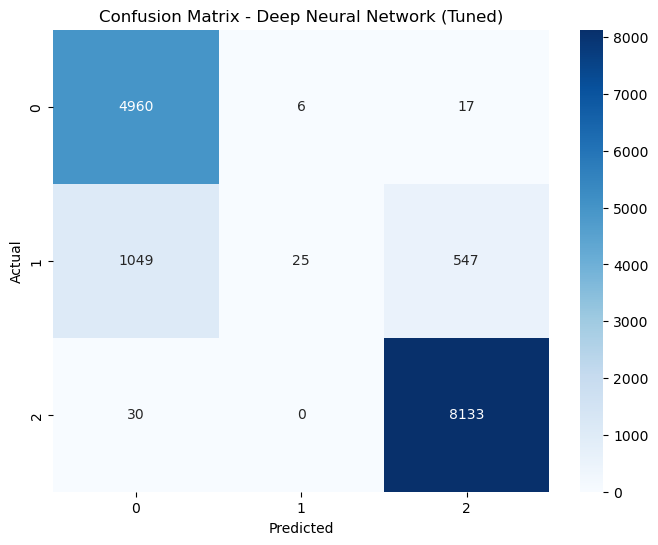

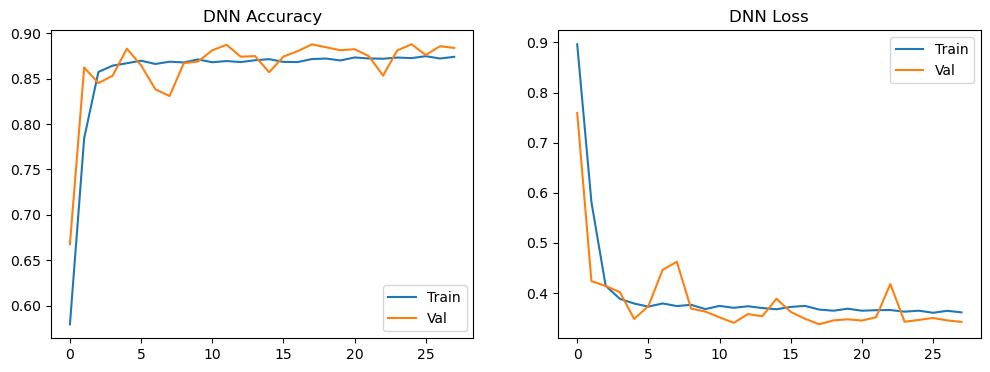

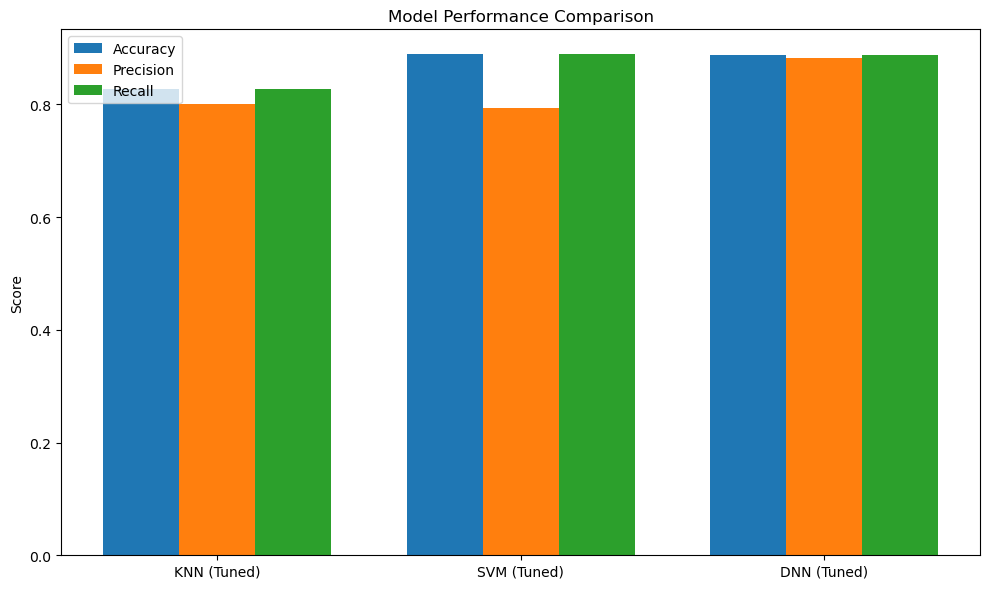


Final Model Comparison:
      Model  Accuracy  Precision   Recall
KNN (Tuned)  0.827995   0.801116 0.827995
SVM (Tuned)  0.888671   0.794098 0.888671
DNN (Tuned)  0.888332   0.882614 0.888332

Hyperparameter Impact Analysis:

KNN - Best Parameters:
- metric: manhattan
- n_neighbors: 11
- p: 1
- weights: distance

SVM - Best Parameters:
- C: 1
- gamma: scale
- kernel: linear

DNN - Best Architecture:
- hidden_units1: 64
- hidden_units2: 32
- hidden_units3: 16
- dropout1: 0.2
- dropout2: 0.1
- learning_rate: 0.001

=== Feature Importance Analysis ===


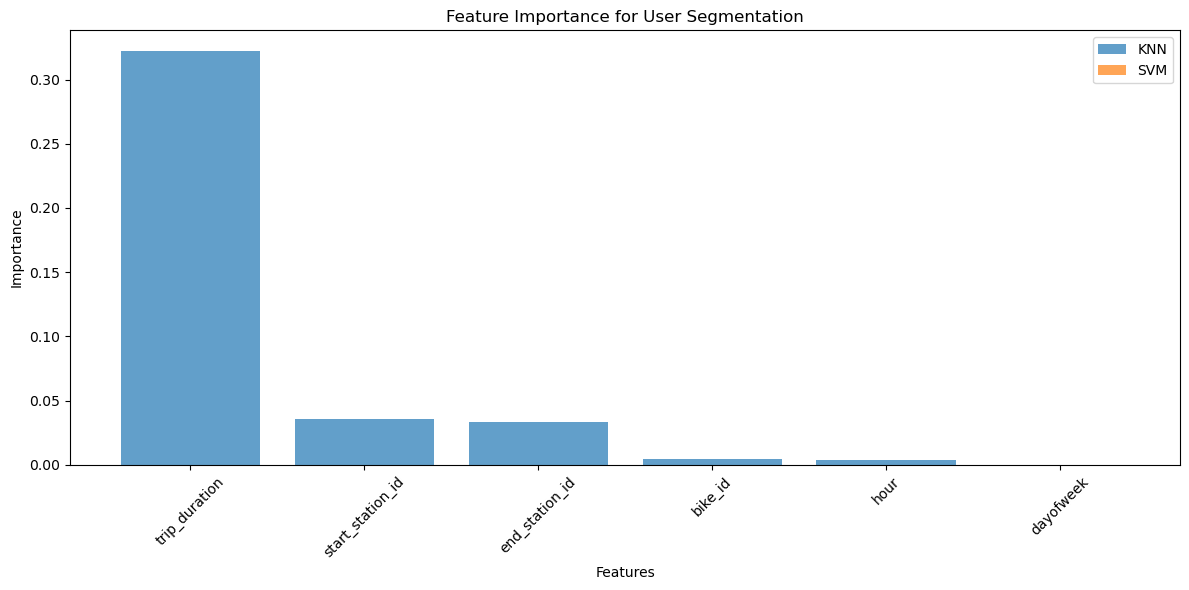


Top Features for User Segmentation:
         Feature  KNN Importance  SVM Importance
   trip_duration        0.322158        0.000021
start_station_id        0.036094        0.000036
  end_station_id        0.033758        0.000012
         bike_id        0.004612        0.000052
            hour        0.004050        0.000051
       dayofweek        0.000000        0.000000

=== User Segment Analysis ===

User Segment Characteristics:
      User Segment  Avg Duration  Median Duration  Min Duration  Max Duration  Avg Hour  Median Hour Most Common Day
        Heavy User   1109.110100            853.0           600         74097 11.485987         11.0          Monday
Potential Customer   1451.523559            801.0            62         83519 11.432331         11.0          Monday
      Regular User    354.690002            352.0            61           599 11.418088         11.0          Monday


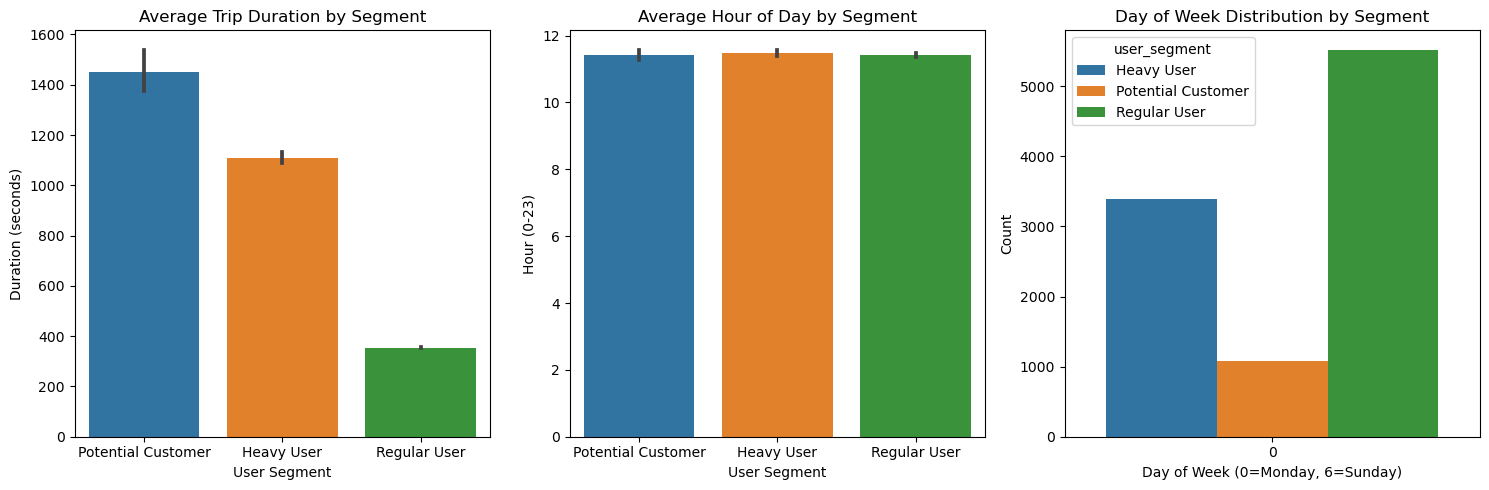


=== Conclusion ===
This analysis has classified users into three segments and identified
the key features that distinguish these segments. The best performing model was SVM (Tuned)

Recommendations for business strategy could include:
1. Targeting 'Potential Customers' with subscription incentives
2. Optimizing bike availability based on usage patterns of 'Regular Users'
3. Designing promotional offers for 'Heavy Users' to maintain their loyalty


In [1]:
# === Part 1: Importing Libraries ===

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Warnings
import warnings
warnings.filterwarnings('ignore')


# Load dataset directly
df = pd.read_csv('fordgobike-tripdataFor201902_updated.csv')

print("Dataset Shape:", df.shape)
print("\nUser Type Distribution:")
print(df['user_type'].value_counts())

# === Part 2: Preprocessing ===

# Drop rows with missing user_type
df = df.dropna(subset=['user_type'])

# Create user_segment based on user_type and trip characteristics
def create_user_segment(row):
    if row['user_type'] == 'Subscriber':
        if row['duration_sec'] < 600:  # Less than 10 minutes
            return 'Regular User'
        else:
            return 'Heavy User'
    else:  # Customer
        return 'Potential Customer'

df['user_segment'] = df.apply(create_user_segment, axis=1)

print("\nUser Segment Distribution:")
print(df['user_segment'].value_counts())

# Encode target variable
le = LabelEncoder()
df['user_segment_encoded'] = le.fit_transform(df['user_segment'])
segment_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nUser Segment Encoding:")
print(segment_mapping)

# Fix and parse start_time
from dateutil.parser import parse

def safe_parse(dt):
    try:
        return parse(dt)
    except:
        return np.nan

df['start_time'] = df['start_time'].apply(safe_parse)
df = df.dropna(subset=['start_time'])

# Extract hour and day of week from start_time
df['hour'] = df['start_time'].dt.hour
df['dayofweek'] = df['start_time'].dt.dayofweek

# Use existing duration_sec column as trip_duration
df['trip_duration'] = df['duration_sec']

# Remove rows with NA in relevant columns
features = ['trip_duration', 'bike_id', 'start_station_id', 'end_station_id', 'hour', 'dayofweek']
df = df.dropna(subset=features)

X = df[features]
y = df['user_segment_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Evaluation Function for Multiclass Classification ===
def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    # For multiclass, we use weighted averages
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, prec, rec

# === Part 3: K-Nearest Neighbors with Hyperparameter Tuning ===
print("\nTuning KNN hyperparameters...")
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Only relevant for Minkowski metric
}

# Use a smaller subset for faster grid search if needed
# Adjust the sampling if the dataset is too large
sample_size = min(10000, len(X_train_scaled))
indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[indices]
y_sample = y_train.iloc[indices]

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

knn_grid.fit(X_sample, y_sample)

print(f"\nBest KNN Parameters: {knn_grid.best_params_}")
print(f"Best CV Score: {knn_grid.best_score_:.4f}")

# Train KNN with best parameters on the full training set
knn = KNeighborsClassifier(**knn_grid.best_params_)
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)
knn_metrics = evaluate_model(y_test, knn_pred, "K-Nearest Neighbors (Tuned)")

# === Part 4: Support Vector Machine with Hyperparameter Tuning ===
print("\nTuning SVM hyperparameters...")
svm_param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# For SVM, we might need an even smaller sample if it's computationally intensive
svm_sample_size = min(2000, len(X_train_scaled))
svm_indices = np.random.choice(len(X_train_scaled), svm_sample_size, replace=False)
X_svm_sample = X_train_scaled[svm_indices]
y_svm_sample = y_train.iloc[svm_indices]

svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid=svm_param_grid,
    cv=3,  # Reduced CV folds for speed
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_svm_sample, y_svm_sample)

print(f"\nBest SVM Parameters: {svm_grid.best_params_}")
print(f"Best CV Score: {svm_grid.best_score_:.4f}")

# Train SVM with best parameters on the full training set
svm = SVC(**svm_grid.best_params_, random_state=42)
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)
svm_metrics = evaluate_model(y_test, svm_pred, "Support Vector Machine (Tuned)")

# === Part 5: Deep Learning (DNN) with Hyperparameter Tuning ===
print("\nTuning Deep Neural Network hyperparameters...")

# Prepare data for DNN
mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

# Get the number of classes from the data
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Define model builder function for KerasClassifier
def create_dnn_model(hidden_units1=128, hidden_units2=64, hidden_units3=32, 
                    dropout1=0.3, dropout2=0.2, learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train_mm.shape[1],)),
        Dense(hidden_units1, activation='relu'),
        Dropout(dropout1),
        Dense(hidden_units2, activation='relu'),
        Dropout(dropout2),
        Dense(hidden_units3, activation='relu'),
        Dense(num_classes, activation='softmax')  # Use num_classes for output layer
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Manual hyperparameter tuning for DNN
print("Testing DNN architectures...")

# Define different hyperparameter configurations to test
dnn_configs = [
    {'hidden_units1': 64, 'hidden_units2': 32, 'hidden_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.001},
    {'hidden_units1': 128, 'hidden_units2': 64, 'hidden_units3': 32, 'dropout1': 0.3, 'dropout2': 0.2, 'learning_rate': 0.001},
    {'hidden_units1': 256, 'hidden_units2': 128, 'hidden_units3': 64, 'dropout1': 0.4, 'dropout2': 0.3, 'learning_rate': 0.0005}
]

dnn_results = []
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Use a validation split from the training data for hyperparameter selection
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train_mm, y_train_cat, test_size=0.2, random_state=42
)

for i, config in enumerate(dnn_configs):
    print(f"\nTrying DNN configuration {i+1}...")
    
    # Build the model with the current configuration
    model = create_dnn_model(**config)
    
    # Train with early stopping
    history = model.fit(
        X_train_val, y_train_val,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )
    
    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Configuration {i+1} - Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
    
    dnn_results.append({
        'config': config,
        'val_accuracy': val_acc,
        'val_loss': val_loss,
        'model': model,
        'history': history
    })

# Find the best configuration
best_dnn = max(dnn_results, key=lambda x: x['val_accuracy'])
print(f"\nBest DNN Configuration: {best_dnn['config']}")
print(f"Best Validation Accuracy: {best_dnn['val_accuracy']:.4f}")

# Use the best model to predict on test set
best_model = best_dnn['model']
dnn_pred_probs = best_model.predict(X_test_mm)
dnn_pred = np.argmax(dnn_pred_probs, axis=1)
dnn_metrics = evaluate_model(y_test, dnn_pred, "Deep Neural Network (Tuned)")

# Plot training history for the best model
history = best_dnn['history']
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('DNN Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('DNN Loss')
plt.legend()
plt.show()

# === Part 6: Model Comparison ===
models = ['KNN (Tuned)', 'SVM (Tuned)', 'DNN (Tuned)']
metrics = np.array([knn_metrics, svm_metrics, dnn_metrics])

# Bar Chart
x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, metrics[:, 0], width, label='Accuracy')
plt.bar(x, metrics[:, 1], width, label='Precision')
plt.bar(x + width, metrics[:, 2], width, label='Recall')

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# Print Summary Table
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': metrics[:, 0],
    'Precision': metrics[:, 1],
    'Recall': metrics[:, 2]
})

print("\nFinal Model Comparison:")
print(comparison_df.to_string(index=False))

# Additional analysis of hyperparameter impact
print("\nHyperparameter Impact Analysis:")
print("\nKNN - Best Parameters:")
for param, value in knn_grid.best_params_.items():
    print(f"- {param}: {value}")

print("\nSVM - Best Parameters:")
for param, value in svm_grid.best_params_.items():
    print(f"- {param}: {value}")

print("\nDNN - Best Architecture:")
for param, value in best_dnn['config'].items():
    print(f"- {param}: {value}")

# === Part 7: Feature Importance Analysis ===
# For a deeper understanding of which features contribute most to user segmentation

print("\n=== Feature Importance Analysis ===")

# For KNN, we can use a permutation-based approach
from sklearn.inspection import permutation_importance

# Calculate feature importance for KNN
knn_importance = permutation_importance(knn, X_test_scaled, y_test, 
                                        n_repeats=10, random_state=42)

# For SVM, we can use the coefficients for linear kernels or permutation importance for non-linear
if svm_grid.best_params_['kernel'] == 'linear':
    svm_importance = {'importances_mean': np.abs(svm.coef_[0])}
else:
    svm_importance = permutation_importance(svm, X_test_scaled, y_test, 
                                           n_repeats=10, random_state=42)

# Create a feature importance dataframe
feature_names = X.columns
knn_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'KNN Importance': knn_importance.importances_mean
})

if svm_grid.best_params_['kernel'] == 'linear':
    knn_importance_df['SVM Importance'] = svm_importance['importances_mean']
else:
    knn_importance_df['SVM Importance'] = svm_importance.importances_mean

# Sort by importance (using KNN as the primary sort key)
knn_importance_df = knn_importance_df.sort_values('KNN Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(knn_importance_df['Feature'], knn_importance_df['KNN Importance'], alpha=0.7, label='KNN')
plt.bar(knn_importance_df['Feature'], knn_importance_df['SVM Importance'], alpha=0.7, label='SVM')
plt.title('Feature Importance for User Segmentation')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print("\nTop Features for User Segmentation:")
print(knn_importance_df.head(10).to_string(index=False))

# === Part 8: User Segment Analysis ===
print("\n=== User Segment Analysis ===")

# Analyze characteristics of each segment
segment_analysis = df.groupby('user_segment').agg({
    'trip_duration': ['mean', 'median', 'min', 'max'],
    'hour': ['mean', 'median'],
    'dayofweek': lambda x: x.value_counts().index[0]  # most common day
}).reset_index()

# Rename the columns for better readability
segment_analysis.columns = ['User Segment', 'Avg Duration', 'Median Duration', 
                           'Min Duration', 'Max Duration', 'Avg Hour', 'Median Hour', 
                           'Most Common Day']

# Map day numbers to day names
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
               3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
segment_analysis['Most Common Day'] = segment_analysis['Most Common Day'].map(day_mapping)

print("\nUser Segment Characteristics:")
print(segment_analysis.to_string(index=False))

# Visualize segment differences
plt.figure(figsize=(15, 5))

# Duration
plt.subplot(1, 3, 1)
sns.barplot(x='user_segment', y='trip_duration', data=df)
plt.title('Average Trip Duration by Segment')
plt.ylabel('Duration (seconds)')
plt.xlabel('User Segment')

# Hour of day
plt.subplot(1, 3, 2)
sns.barplot(x='user_segment', y='hour', data=df)
plt.title('Average Hour of Day by Segment')
plt.ylabel('Hour (0-23)')
plt.xlabel('User Segment')

# Day of week distribution
plt.subplot(1, 3, 3)
df_sample = df.sample(min(10000, len(df)))  # Sample for faster plotting
sns.countplot(x='dayofweek', hue='user_segment', data=df_sample)
plt.title('Day of Week Distribution by Segment')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("\n=== Conclusion ===")
print("This analysis has classified users into three segments and identified")
print("the key features that distinguish these segments. The best performing model was", 
      models[np.argmax(metrics[:, 0])])
print("\nRecommendations for business strategy could include:")
print("1. Targeting 'Potential Customers' with subscription incentives")
print("2. Optimizing bike availability based on usage patterns of 'Regular Users'")
print("3. Designing promotional offers for 'Heavy Users' to maintain their loyalty")